In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false' # prevent JAX from allocating all GPU memory

In [2]:
from functools import partial

import numpy as np
import pandas as pd
import math
import plotly.express as px
import matplotlib.pyplot as plt 
from ipywidgets import interact, interactive

import tensorflow as tf
from tensorflow.keras.models import Model

tf.config.set_visible_devices([], 'GPU')   # workaround on mac M1 

In [3]:
import jax
from jax import jit
from jax import lax
from jax import vmap
import jax.numpy as jnp
from jax.experimental import jax2tf

from jax_control_algorithms.plot_helpers import plot_states, plot_output_comparison, plot_state_comparison
from load_video import load_dataset_single_video, load_video
from uncontrolled_pendulum import *
from pendulum_nn_models import *
from pendulum_nn_helper import *

jax.config.update('jax_enable_x64', True)

In [4]:
%config InlineBackend.figure_formats = ['svg']

# Eval autotrain

Load the data produced by the notebook pendulum_nn_autotrain.ipynb

In [5]:
#data = ExperimentalData('trained_models/autorun_xx')
data = ExperimentalData('trained_models/autorun_13')

# show the performed experiments and the used parameters
pd.merge( left=data.pdf_training_tasks, right=data.pdf_results, on='task_id' )

,scenario_x,task_id,learning_rate,lambda_ml,lambda_mv,lambda_pendulum_fit,lambda_stability,wy1,wy2,wx1,wx2,lambda_exp,n_epochs,model_fnames,scenario_y,loss_history
0,redapple,1,0.001,1.0,1.0,1.0,0.01,1.0,1.0,100.0,100.0,0.0,"[200, 200, 200, 200, 500, 500, 500, 500, 500, ...","[redapple/1/snapshot_0/model, redapple/1/snaps...",redapple,"[1.6758265495300293, 1.1198058128356934, 0.339..."
1,zucchini,2,0.001,1.0,1.0,1.0,0.01,1.0,1.0,100.0,100.0,0.0,"[200, 200, 200, 200, 500, 500, 500, 500, 500, ...","[zucchini/2/snapshot_0/model, zucchini/2/snaps...",zucchini,"[1.6566965579986572, 2.2260820865631104, 0.923..."
2,redapple,3,0.001,1.0,1.0,1.0,0.01,1.0,1.0,100.0,100.0,2.0,"[200, 200, 200, 200, 500, 500, 500, 500, 500, ...","[redapple/3/snapshot_0/model, redapple/3/snaps...",redapple,"[1.4564054012298584, 0.17629793286323547, 2.10..."
3,zucchini,4,0.001,1.0,1.0,1.0,0.01,1.0,1.0,100.0,100.0,2.0,"[200, 200, 200, 200, 500, 500, 500, 500, 500, ...","[zucchini/4/snapshot_0/model, zucchini/4/snaps...",zucchini,"[2.1123898029327393, 0.25022244453430176, 0.68..."


### Choose the task to display

In [8]:
index = 0
task = data.pdf_training_tasks.iloc[index]
task.scenario

'redapple'

In [9]:
# load
pe_autoencoder, x_train, mean_picture, T_batch, picture_shape, max_time, dt = load_train_data_and_model(data, task)

loading pendulum_videos/redapple_480p.mov


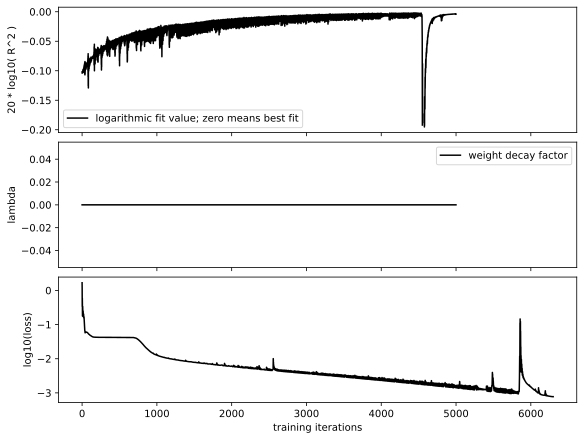

In [10]:
plot_full_training_history(data, task, pe_autoencoder)

# Final estimate of pendulum motion

2023-03-08 20:02:39.124778: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


theta=[ 8.528030395507812, 0.015213264152407646, -0.002854892984032631 ]
J_pendulum_fit = 0.0003686351119540632
R^2 = 0.9995486542349772  20*log10(R^2) = -0.003921224484210589


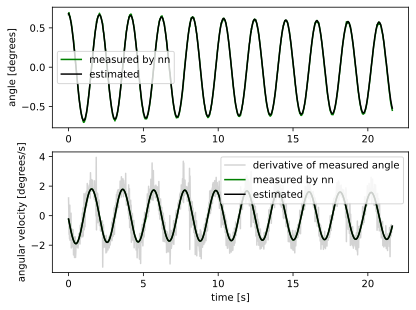

In [11]:
plot_time_eval(pe_autoencoder, x_train, T_batch, dt)

In [12]:
# plot_eval_task_single_snapshot(data, task)

# Show all intermediate training results

loading pendulum_videos/redapple_480p.mov
snapshot #0 redapple/1/snapshot_0/model
theta=[ 3.887953519821167, 0.0060544079169631, -0.002300709718838334 ]
J_pendulum_fit = 1.3340019904717337e-05
R^2 = 0.9761167860746597  20*log10(R^2) = -0.2099643738478537


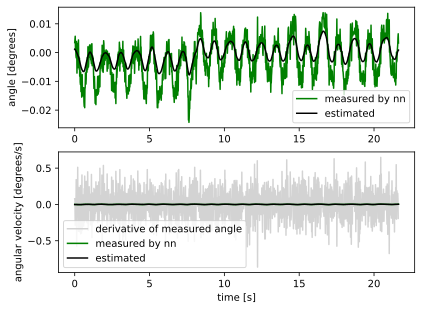

snapshot #1 redapple/1/snapshot_1/model
theta=[ 3.861191749572754, 0.006053909659385681, -0.0008369639981538057 ]
J_pendulum_fit = 1.8294276742381044e-05
R^2 = 0.9730014022385381  20*log10(R^2) = -0.2377306769758063


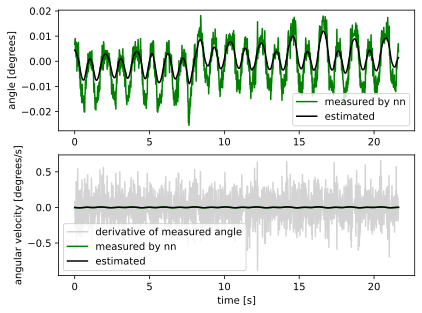

snapshot #2 redapple/1/snapshot_2/model
theta=[ 3.8380279541015625, 0.006062031723558903, -0.0004628883907571435 ]
J_pendulum_fit = 3.695600389619358e-05
R^2 = 0.9510210768479562  20*log10(R^2) = -0.43619715952027155


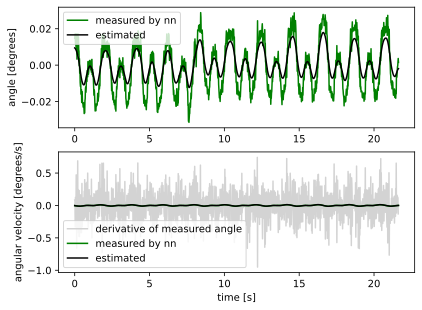

snapshot #3 redapple/1/snapshot_3/model
theta=[ 3.31261944770813, 0.008179769851267338, 0.0014124945737421513 ]
J_pendulum_fit = 0.011738752946257591
R^2 = 0.7702201752222335  20*log10(R^2) = -2.2677021922473166


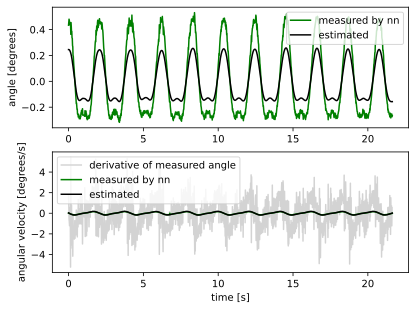

snapshot #4 redapple/1/snapshot_4/model
theta=[ 3.849182367324829, 0.02719198353588581, -0.0016488649416714907 ]
J_pendulum_fit = 0.006664236541837454
R^2 = 0.9882459088099848  20*log10(R^2) = -0.10269949790728967


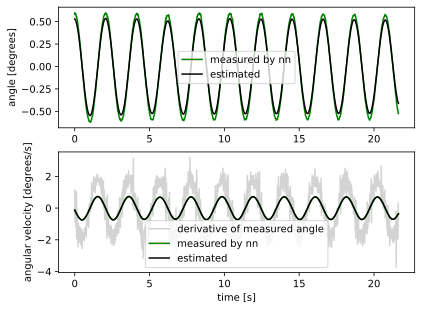

snapshot #5 redapple/1/snapshot_5/model
theta=[ 4.684074878692627, 0.02631113864481449, -0.0027854435611516237 ]
J_pendulum_fit = 0.005239472258836031
R^2 = 0.992343203289606  20*log10(R^2) = -0.06676201020120012


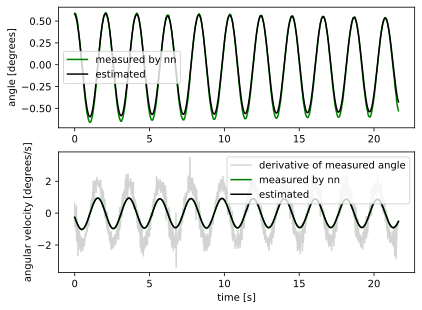

snapshot #6 redapple/1/snapshot_6/model
theta=[ 5.3051533699035645, 0.027538936585187912, -0.002807888202369213 ]
J_pendulum_fit = 0.004061942454427481
R^2 = 0.9958993410201346  20*log10(R^2) = -0.03569109997342185


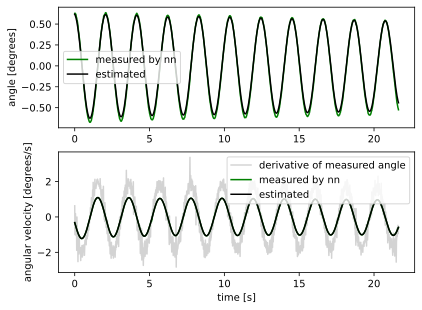

snapshot #7 redapple/1/snapshot_7/model
theta=[ 5.829841136932373, 0.02560846135020256, -0.0029448503628373146 ]
J_pendulum_fit = 0.0033030626364052296
R^2 = 0.9965809164336846  20*log10(R^2) = -0.029748668141658694


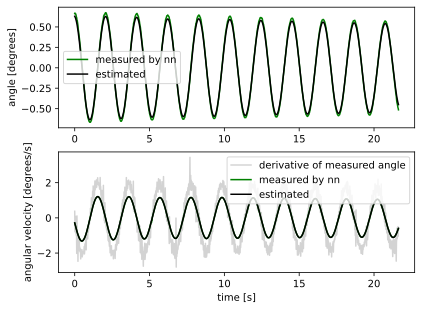

snapshot #8 redapple/1/snapshot_8/model
theta=[ 6.306718826293945, 0.025764675810933113, -0.002846691757440567 ]
J_pendulum_fit = 0.0025268772151321173
R^2 = 0.9981570343466348  20*log10(R^2) = -0.016022565329932605


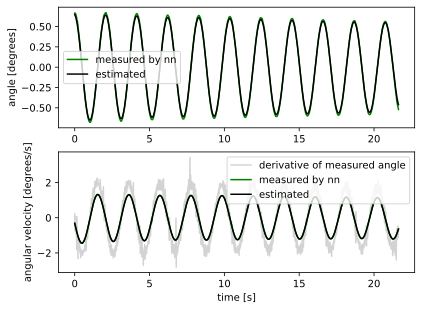

snapshot #9 redapple/1/snapshot_9/model
theta=[ 6.751379013061523, 0.025757502764463425, -0.002843644702807069 ]
J_pendulum_fit = 0.002017008839175105
R^2 = 0.9980000386438967  20*log10(R^2) = -0.017388837923303428


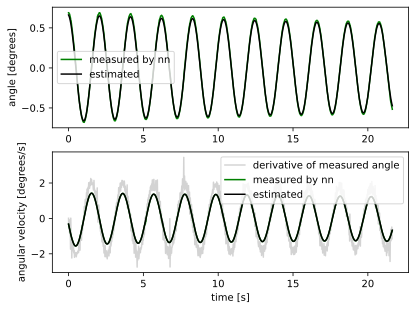

snapshot #10 redapple/1/snapshot_10/model
theta=[ 7.1652913093566895, 0.024994518607854843, -0.0028082658536732197 ]
J_pendulum_fit = 0.001474347896873951
R^2 = 0.9986522851567554  20*log10(R^2) = -0.011713997730553618


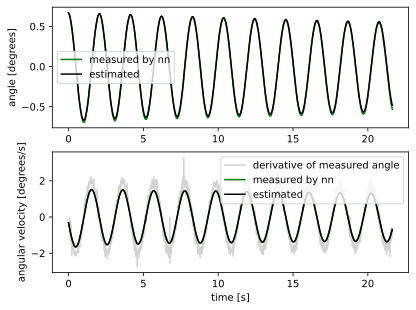

snapshot #11 redapple/1/snapshot_11/model
theta=[ 7.551368713378906, 0.023690592497587204, -0.0028644611593335867 ]
J_pendulum_fit = 0.001051267609000206
R^2 = 0.9994151820678663  20*log10(R^2) = -0.005081149935534192


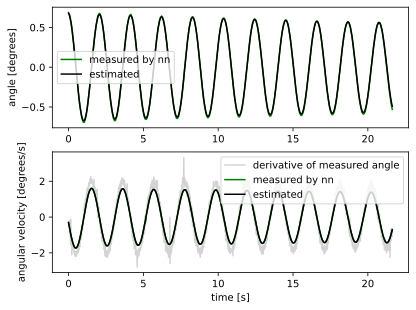

snapshot #12 redapple/1/snapshot_12/model
theta=[ 7.9101948738098145, 0.022429920732975006, -0.002944430336356163 ]
J_pendulum_fit = 0.0007657295209355652
R^2 = 0.9994360242404645  20*log10(R^2) = -0.004900013080083428


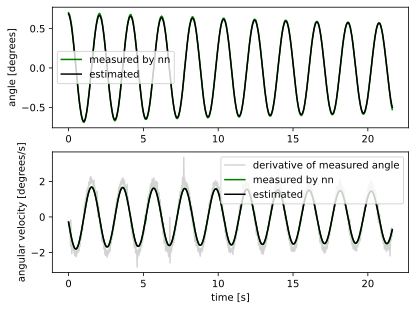

snapshot #13 redapple/1/snapshot_13/model
theta=[ 8.234469413757324, 0.020069818943738937, -0.003008707892149687 ]
J_pendulum_fit = 0.0005369660793803632
R^2 = 0.9995286903192969  20*log10(R^2) = -0.004094708885722678


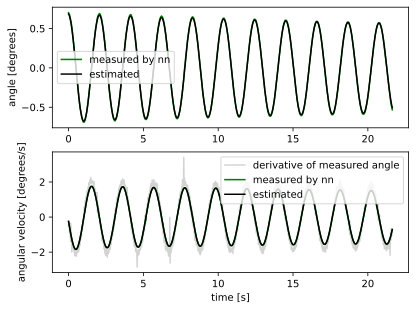

snapshot #14 redapple/1/snapshot_14/model
theta=[ 8.528030395507812, 0.015213264152407646, -0.002854892984032631 ]
J_pendulum_fit = 0.0003686351119540632
R^2 = 0.9995486542349772  20*log10(R^2) = -0.003921224484210589


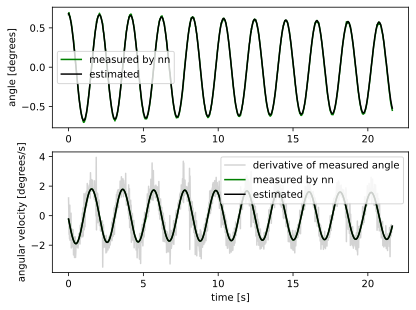

In [13]:
plot_eval_task(data, task)

# Animation

In [ ]:
animation = make_video_from_eval_task(data, task)

# displaying animation with auto play and looping
animation.ipython_display(fps = 60, loop = True, autoplay = True)    